In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import neo

import numpy as np
import pandas as pd

from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import FloatVector
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import scipy.stats

from collections import Counter

import matplotlib.gridspec as gridspec

import os

In [9]:
# ro.r('source("burstanalysis/CMA_method.R")')
# ro.r('source("burstanalysis/hennig_method.R")')
# ro.r('source("burstanalysis/logisi_pasq_method.R")')
# ro.r('source("burstanalysis/PS_method.R")')
# ro.r('source("burstanalysis/RGS_method.R")')
# ro.r('source("burstanalysis/RS_method.R")')
# ro.r('source("burstanalysis/MI_method.R")')

# ro.r(' mi.par <- list(beg.isi =    0.17,  end.isi =    0.3, min.ibi =    0.2, min.durn =   0.01, min.spikes = 3)')

In [10]:
# methods = [('logisi', 'data.frame(logisi.pasq.method(spikes))'), 
#            ('robust surprise', 'data.frame(RS.method(spikes,RS.thresh=4.5))'),
#            ('robust gaussian', 'data.frame(RGS.method(spikes, thresh=4.5))'),
#           ('poisson surprise', 'data.frame(PS.method(spikes,si.thresh=3))'),
#           ('Cumulative moving average', 'data.frame(CMA.method(spikes))'), 
#            ('henning', 'data.frame(hennig.method(spikes))'),
#           ('MI', 'data.frame(MI.method(spikes))')]

In [11]:
def plot_spikes(spikes, burst_spikes, mname, df=None, dname=None):
    isi = spikes[1:] - spikes[:-1]

    cv = scipy.stats.variation(isi)
    ai = np.median(isi)/np.mean(isi)
    
    f, axarr = plt.subplots(2, sharex=True, figsize=(15,10))

    for i in range(spikes.shape[0]):
        axarr[0].plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.2)

        if burst_spikes[i] == True:
            axarr[1].plot([spikes[i], spikes[i]], [-1, 1], color='red', lw=0.2)
#             axarr[2].plot([spikes[i], spikes[i]], [-1, 1], color='red', lw=0.5)
#         else:
#             axarr[2].plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.5)
    
    if not (df is None):
        for s, e in zip(res['beg'], res['end']):
            s -= 1
            e -= 1

            s, e = int(s), int(e)

            axarr[1].plot([spikes[s], spikes[e]], [-1.1, -1.1], color='green')

    axarr[0].set_ylim([-5, 5])
    axarr[1].set_ylim([-5, 5])
    axarr[0].set_title('{} raw spikes, cv: {}, ai: {}'.format(mname, round(cv, 3), round(ai, 3)))
    axarr[1].set_title('{} burst spikes, {}%'.format(mname, round(100.*sum(burst_spikes)/len(spikes), 3)))

    plt.show()


In [12]:
def spiketrains_iterator(handler):
    for blk in handler.read(cascade=True, lazy=False):
        for seg in blk.segments:
            for st in seg.spiketrains:
                yield st.name, np.array(st)
                
def events_iterator(handler):
    for blk in handler.read(cascade=True, lazy=False):
        for seg in blk.segments:
            for st in seg.events:
                yield st.annotations['channel_name'], np.array(st)

In [25]:
SPIKES_RV = scipy.stats.poisson(1.)

def clever_split(arr, step):
    res = list()
    
    idx = 0
    for l in np.arange(0, arr[~0], step):
        curr = list()
        while(idx < len(arr) and arr[idx] < l + step):
            curr.append(arr[idx])
            idx += 1
        
        res.append(curr)
    
    return res


def calc_discharge_rate(spikes):
    return 1.*len(spikes)/(spikes[~0] - spikes[0])

def bin_by_discharge(spikes, coeff=2):
    return coeff/calc_discharge_rate(spikes)


def median_of_three_smoothing(hist):
    res = np.array(hist)
    res[0] = np.median([hist[0], hist[0], hist[1]])
    for i in range(1, hist.shape[0]-1):
        res[i] = np.median(hist[i-1:i+2])
    res[-1] = np.median([hist[-2], hist[-1], hist[-1]])

    return res


def find_by_bin(hist):
    d = None
    for i in range(1, hist.shape[0] - 1):
        if hist[i] < hist[i-1] and hist[i] <= hist[i+1]:
            d = i
            break

    return d


def find_by_slope(hist):
    d = None
    slope, _, _, _, _ = scipy.stats.linregress(list(range(len(hist))), hist)
    slope = abs(slope)
    for i in range(1, hist.shape[0]):
        if abs(hist[i] - hist[i-1]) < slope:
            d = i
            break

    return d


def find_threshold_density(hist):
    d = find_by_bin(hist)

    if d is None:
        d = find_by_slope(hist)

    if d is None:
        raise 'Wow, cant find density threshold!'

    return d

def calc_bin_isi_std(spikes):
    isi = spikes[1:] - spikes[:-1]
    return np.std(isi)

def detect_with_vitek(spikes, min_spikes=3, bin_func=bin_by_discharge):
    spikes = np.array(spikes)
        
#     t = 1./calc_discharge_rate(spikes)*2
#     t = np.std(sp_isi)
    t = bin_func(spikes)
    print('t: {}'.format(round(t, 3)))

    counts = list(map(len, clever_split(spikes, t)))
    nums, vals = zip(*sorted(Counter(counts).items()))

    vals = median_of_three_smoothing(np.array(vals, dtype=float))

    ch2_test = scipy.stats.chisquare(vals, SPIKES_RV.pmf(nums)*len(spikes))[1]
    skew_test = scipy.stats.skew(counts)

    burst_spikes = np.zeros(spikes.shape[0], dtype=bool)
    burst_isi = np.zeros(spikes.shape[0]-1, dtype=bool) 
    
    if(ch2_test < 0.05 and skew_test > 0.5):
        d = find_threshold_density(vals)

        isi_t = t/d
        
        print('isi_t: {}'.format(round(isi_t, 3)))
        isi = np.ediff1d(spikes)
        burst_isi = np.array(isi <= isi_t, dtype=bool)      
        
        prev = 0
        counter = 0
        for idx, i in enumerate(burst_isi):
            if i:
                counter += 1
            else:
                burst_isi[prev:idx] = (counter >= min_spikes - 1)
                burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
                counter = 0   
                prev = idx + 1
                
        burst_isi[prev:idx] = (counter >= min_spikes - 1)
        burst_spikes[prev:idx+1] = (counter >= min_spikes - 1)
        
        return burst_spikes, burst_isi, vals
    else:
        return np.zeros(spikes.shape[0], dtype=bool), np.zeros(spikes.shape[0]-1, dtype=bool), vals

In [33]:
def detect_plot(nm, st, bin_func_name='discharge'):
    if bin_func_name == 'discharge':
        bin_func = bin_by_discharge
    else:
        bin_func = calc_bin_isi_std
    
    vitek_bursts, burst_isi, hist = detect_with_vitek(st, bin_func=bin_func)
    isi = st[1:] - st[:-1]
    
    fig = plt.figure(figsize=(15,10))
    gridspec.GridSpec(3,3)

    plt.subplot2grid((3, 3), (0,1))
    plt.bar(np.arange(hist.shape[0]), hist)
    plt.plot(SPIKES_RV.pmf(np.arange(hist.shape[0]))*len(st), color='black')
    plt.title('SDH, method: {}'.format(bin_func_name))
    
    plt.subplot2grid((3, 3), (1,0), colspan=3)
    for s in st:
        plt.plot([s, s], [-1, 1], color='black', lw=0.3)
        
    plt.ylim([-5, 5])      
    plt.xlim([-0.5, st[~0] + 0.5])
    plt.title('raw spikes, name: {}'.format(nm))
    
    plt.subplot2grid((3, 3), (2,0), colspan=3)
    for s in st[vitek_bursts]:
        plt.plot([s, s], [-1, 1], color='red', lw=0.3)
        
    for idx, i in enumerate(burst_isi):
        if i:
            plt.plot([st[idx], st[idx+1]], [-1.2, -1.2], color='green')
    
    plt.ylim([-5, 5])
    plt.xlim([-0.5, st[~0] + 0.5])
    plt.title('burst spikes, ai: {}'.format(round(np.median(isi)/np.mean(isi), 3)))    
    
    return vitek_bursts, burst_isi

t: 0.041
isi_t: 0.006
t: 0.041
isi_t: 0.006


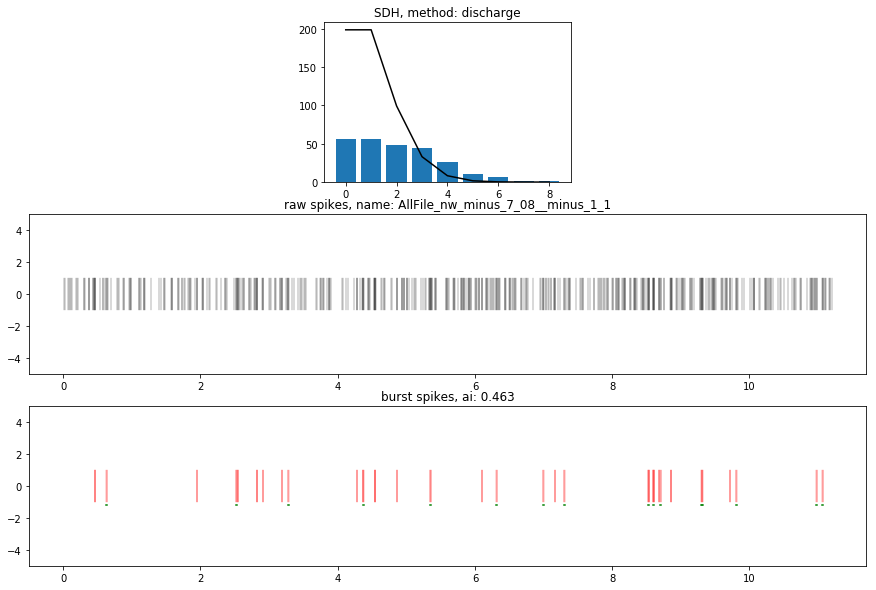

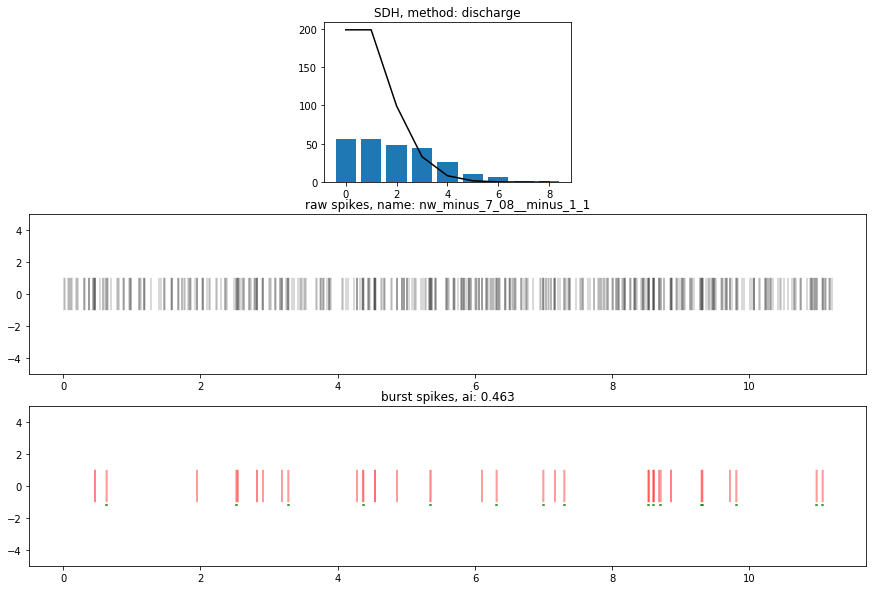

In [34]:
fname = 'pattern_data/LT1D01.28.nex'
r = neo.io.NeuroExplorerIO(fname)

for idxst, (name, spikes) in enumerate(spiketrains_iterator(r)):
    if len(spikes) < 50:
        continue
        
    burst_isi, burst_spikes = detect_plot(name, spikes, 'discharge')
    
    plt.savefig('images/{}_{}_std.png'.format(os.path.split(fname)[~0], name))

t: 0.025
isi_t: 0.005
t: 0.025
isi_t: 0.005


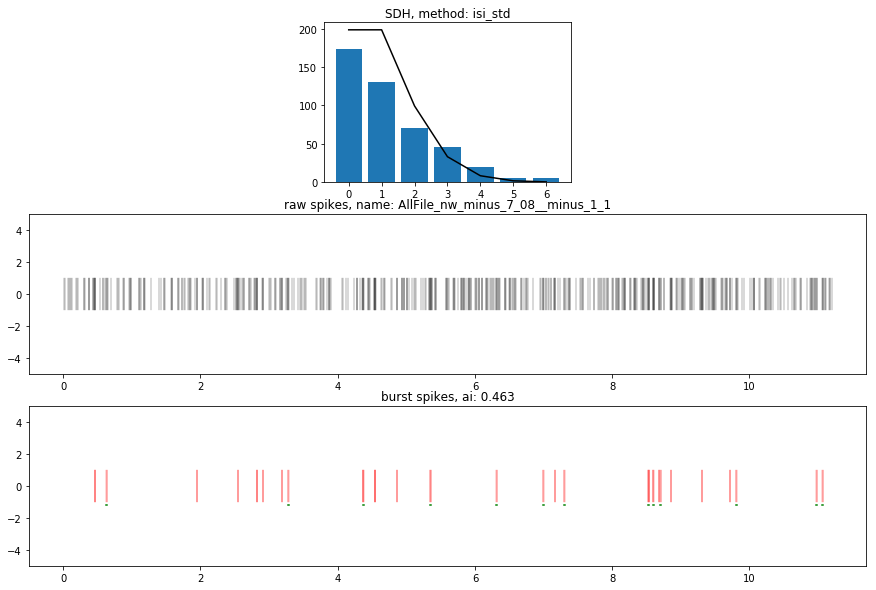

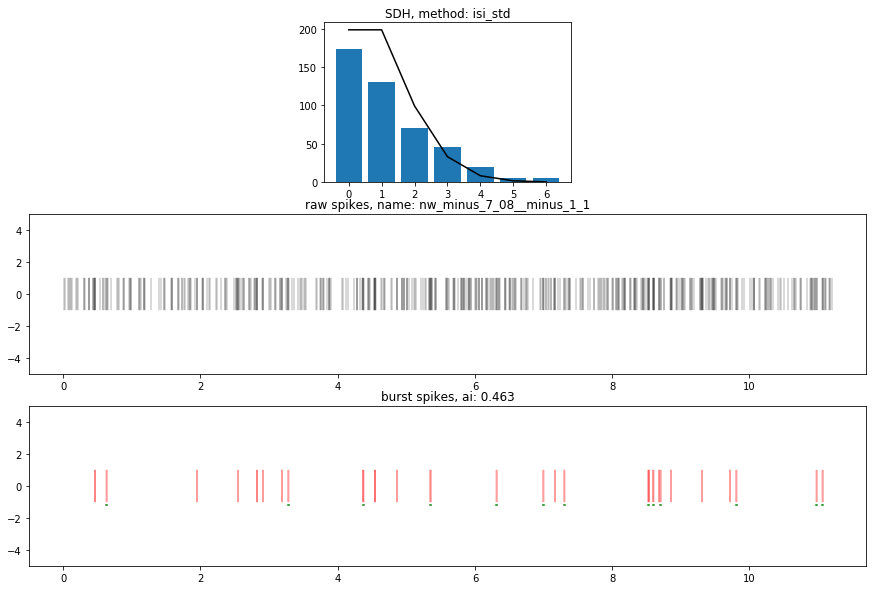

In [35]:
fname = 'pattern_data/LT1D01.28.nex'
r = neo.io.NeuroExplorerIO(fname)

for idxst, (name, spikes) in enumerate(spiketrains_iterator(r)):
    if len(spikes) < 50:
        continue
        
    burst_isi, burst_spikes = detect_plot(name, spikes, 'isi_std')
    
    plt.savefig('images/{}_{}_std.png'.format(os.path.split(fname)[~0], name))

t: 0.185
isi_t: 0.062
t: 0.243
isi_t: 0.243
t: 0.154
isi_t: 0.077
t: 0.126
isi_t: 0.063
t: 0.125
isi_t: 0.125
t: 0.064
isi_t: 0.064
t: 0.045
isi_t: 0.022
t: 0.326
isi_t: 0.054
t: 0.135
t: 0.226
isi_t: 0.057
t: 0.339
isi_t: 0.068
t: 0.163
isi_t: 0.041
t: 0.242
isi_t: 0.061
t: 0.154
isi_t: 0.022
t: 0.08
isi_t: 0.027
t: 0.104
isi_t: 0.013
t: 0.383
isi_t: 0.096
t: 0.437
isi_t: 0.219
t: 0.185
isi_t: 0.092
t: 0.065
isi_t: 0.065
t: 0.123
isi_t: 0.062


C:\Users\vladka\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


t: 0.06
isi_t: 0.008
t: 0.075
isi_t: 0.025


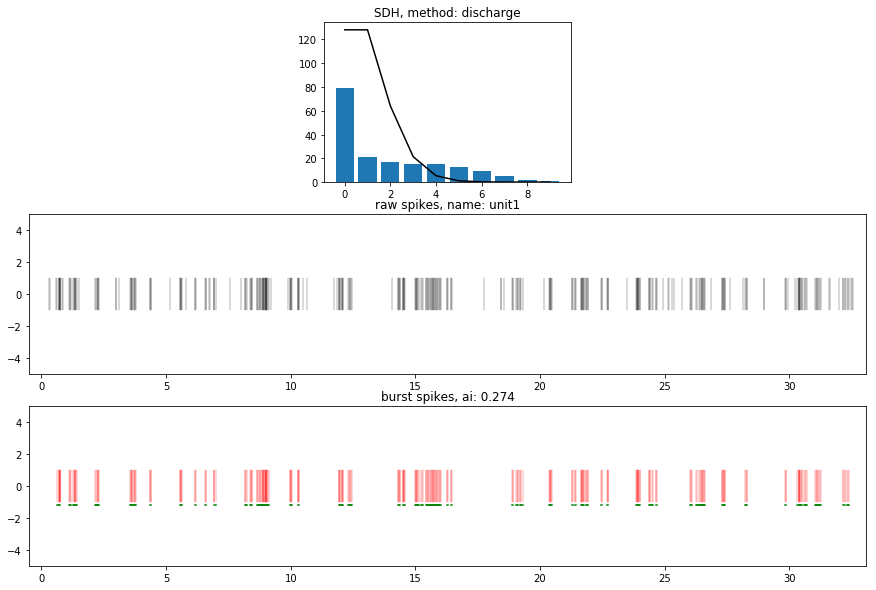

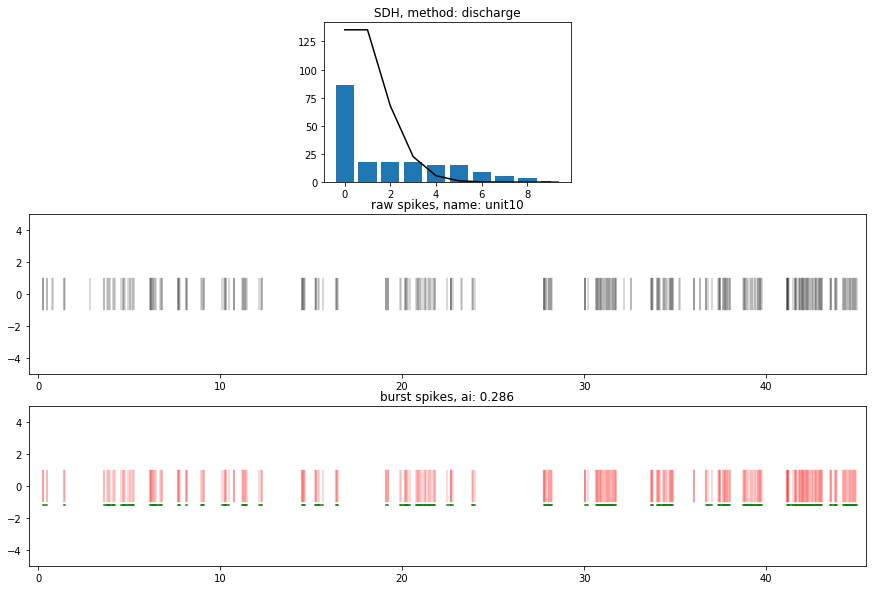

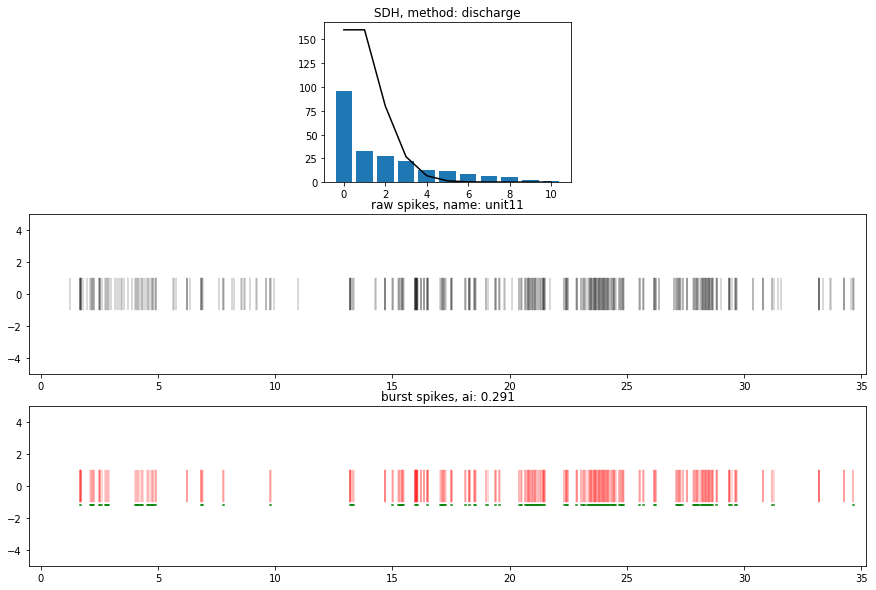

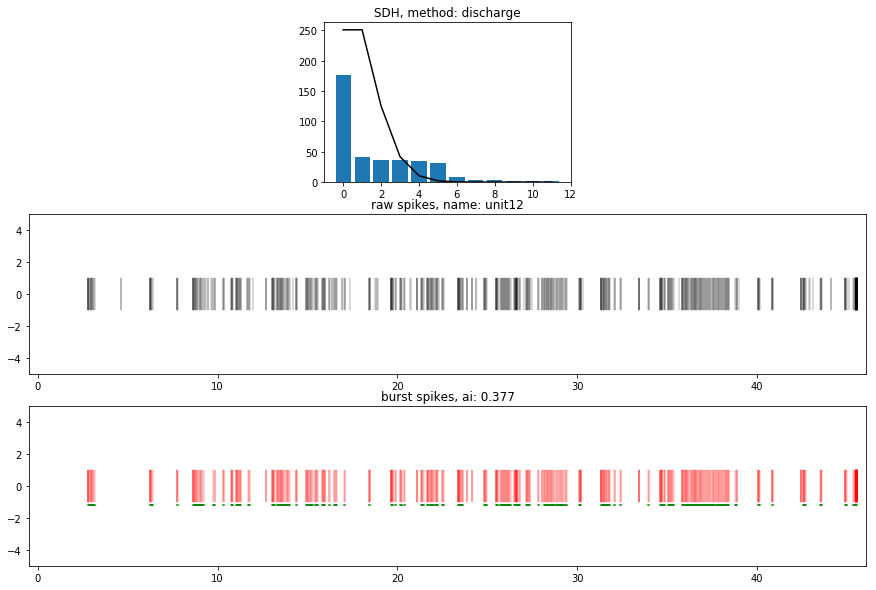

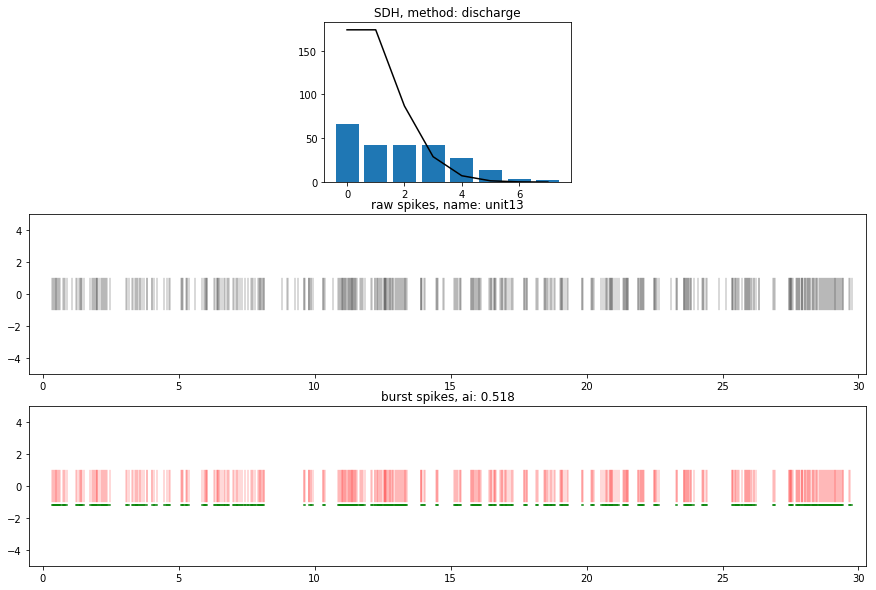

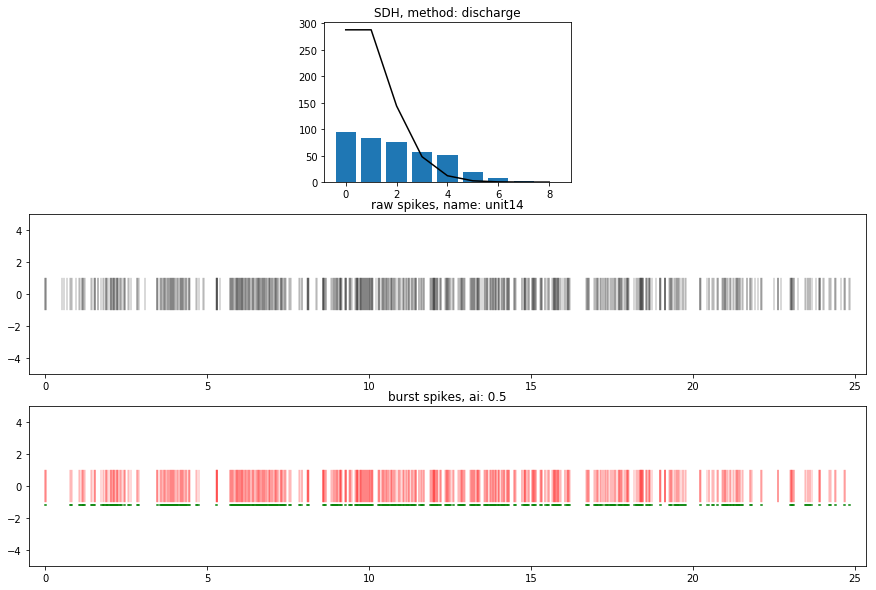

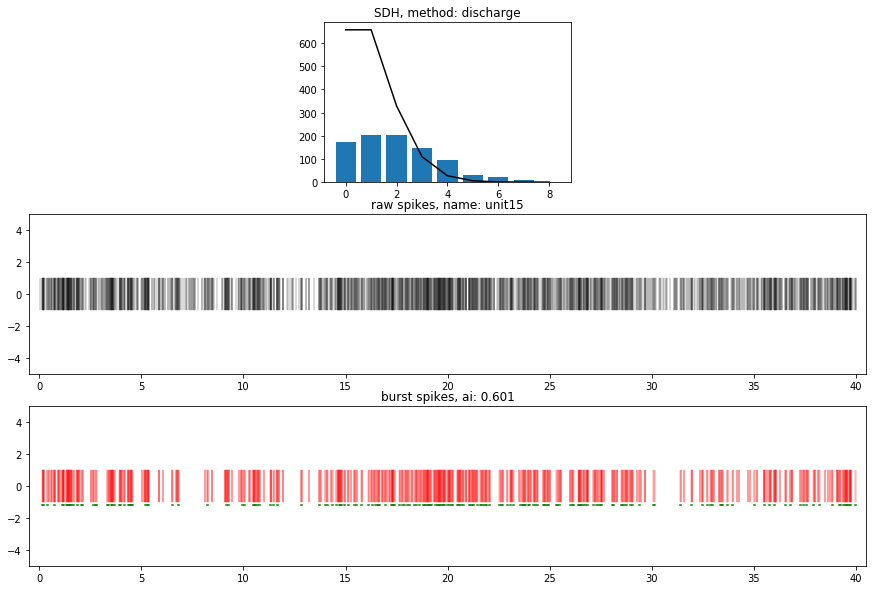

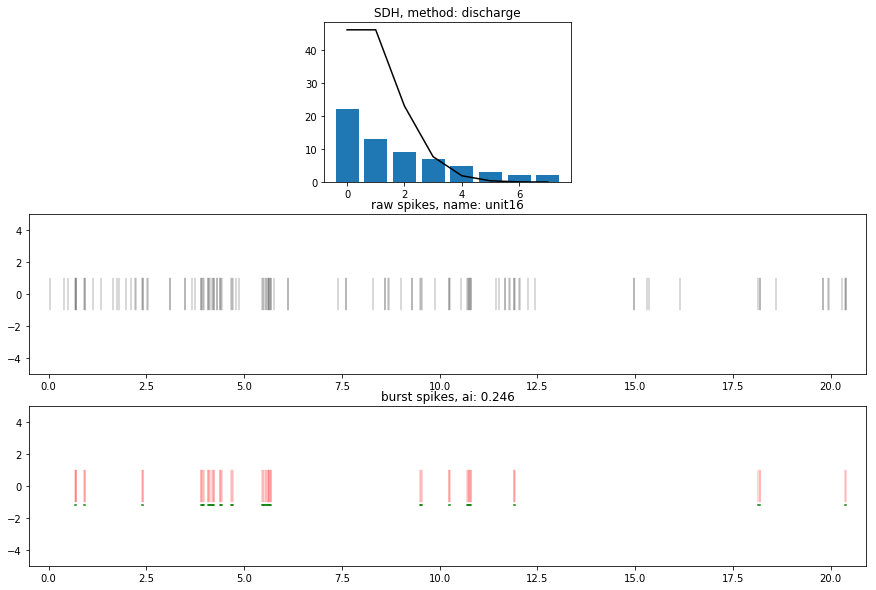

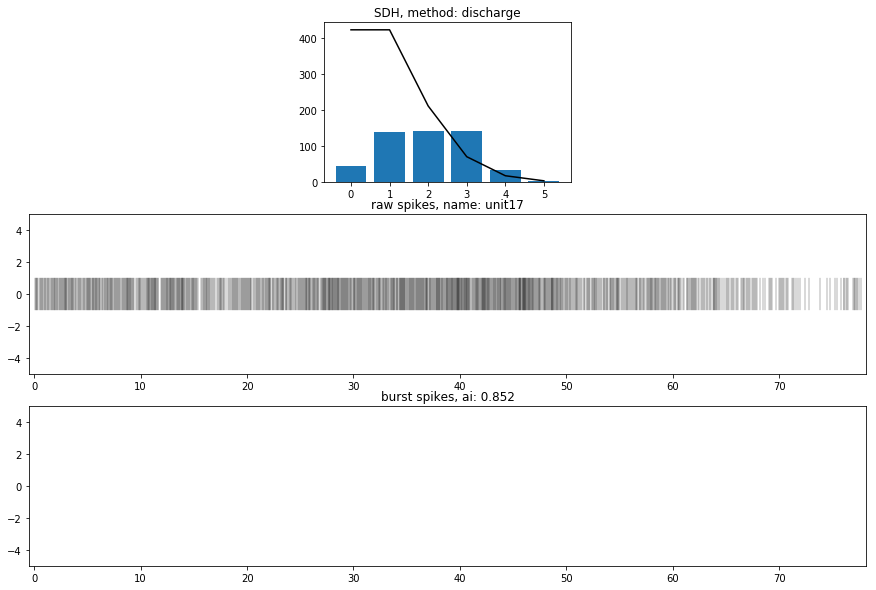

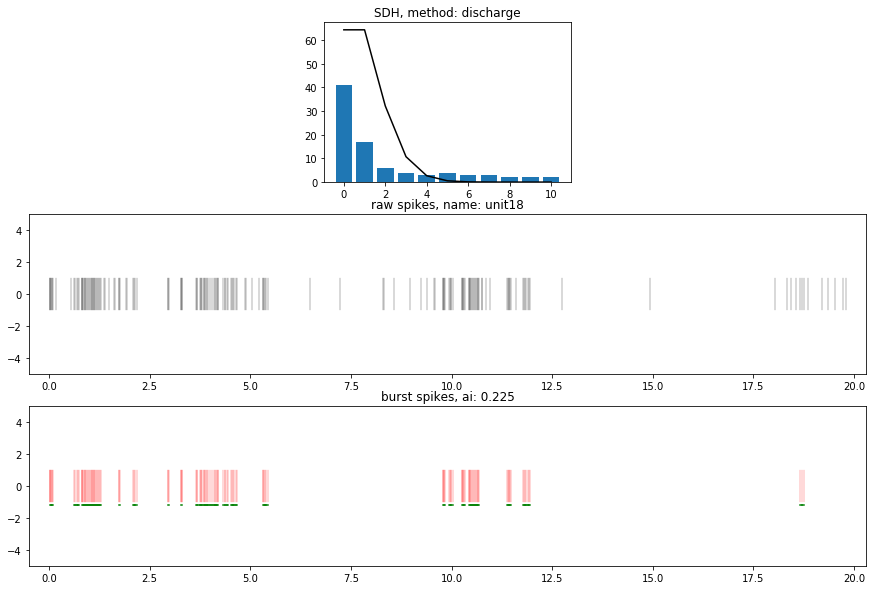

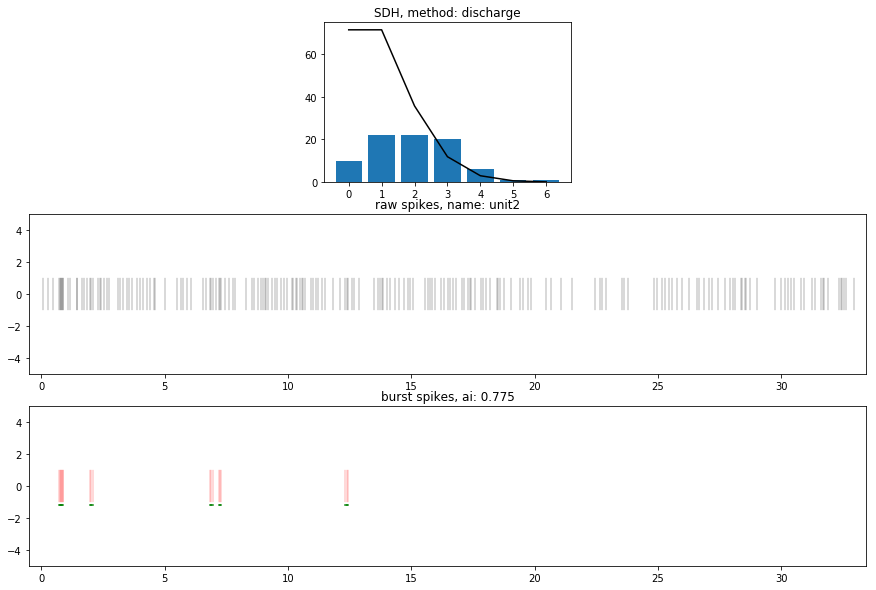

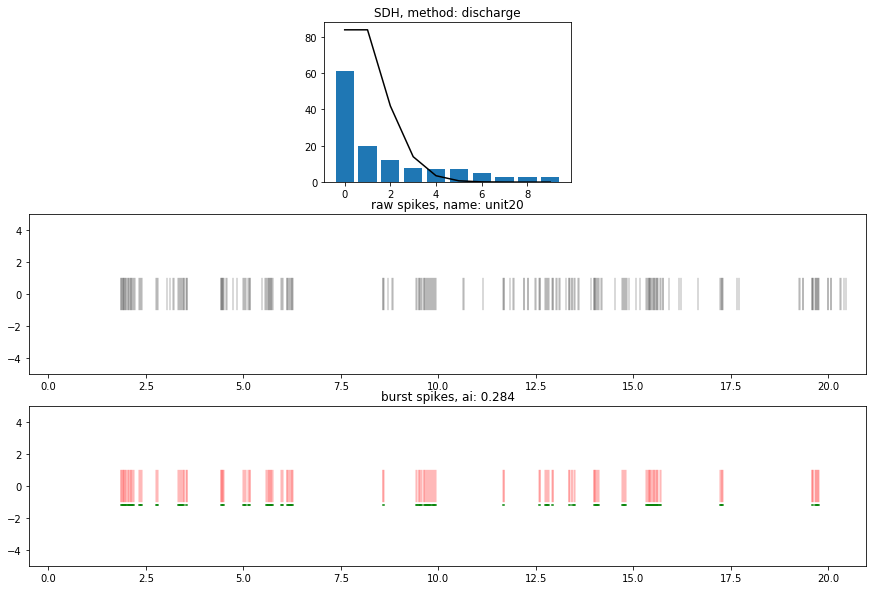

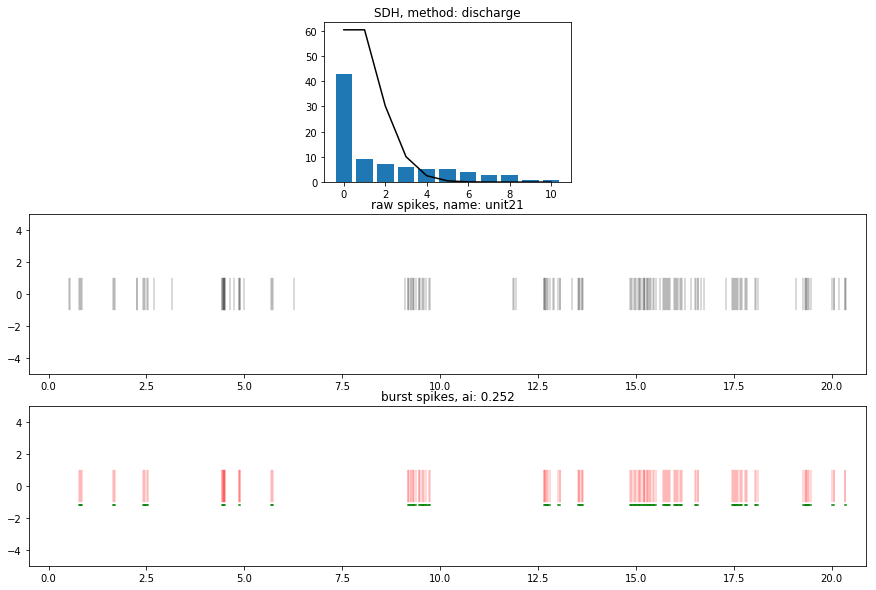

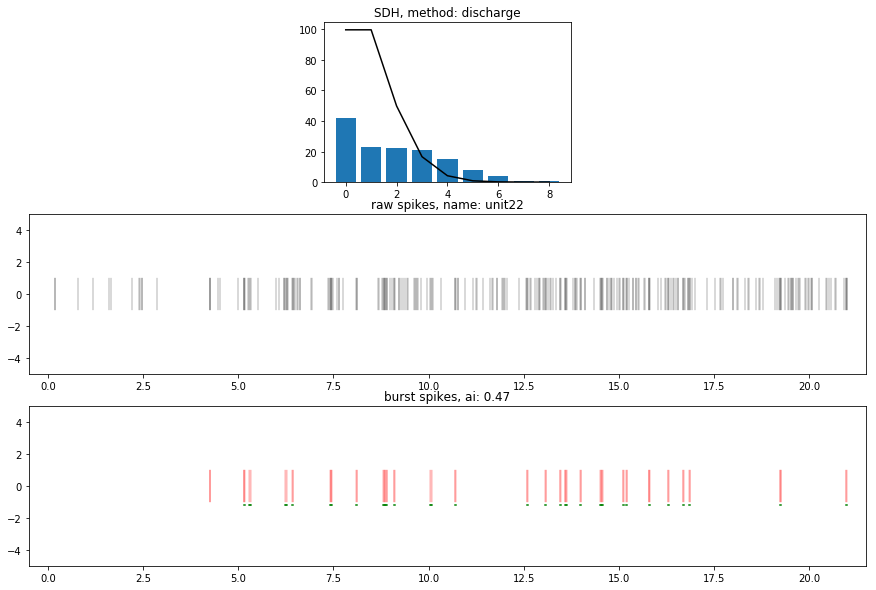

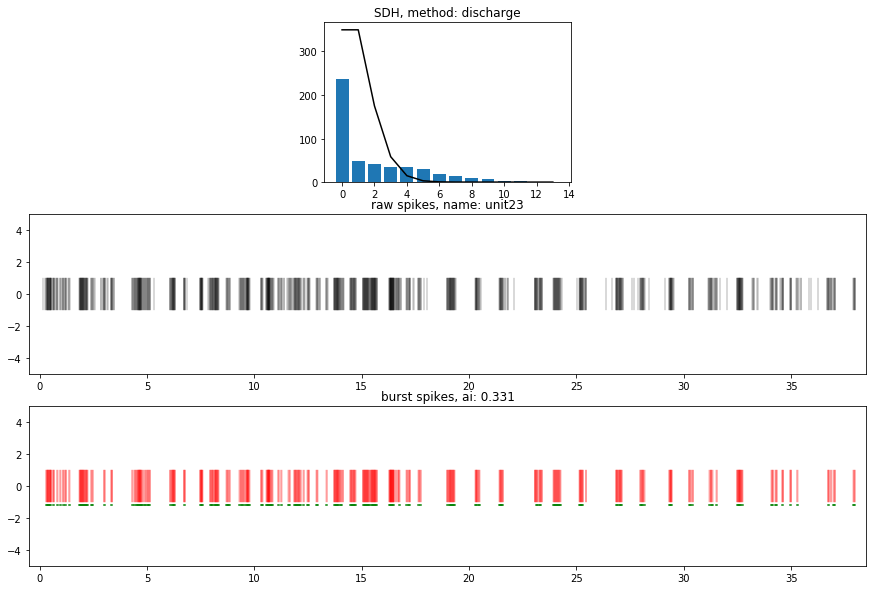

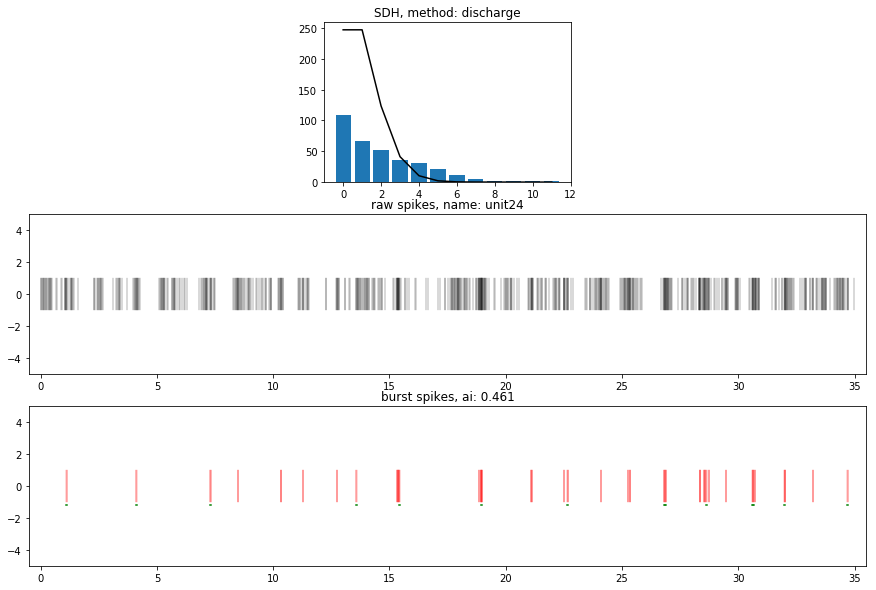

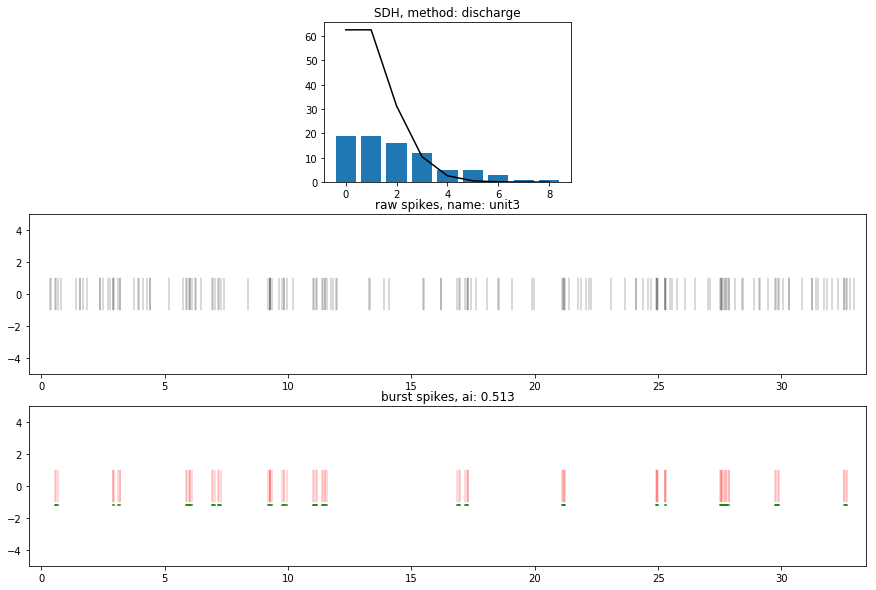

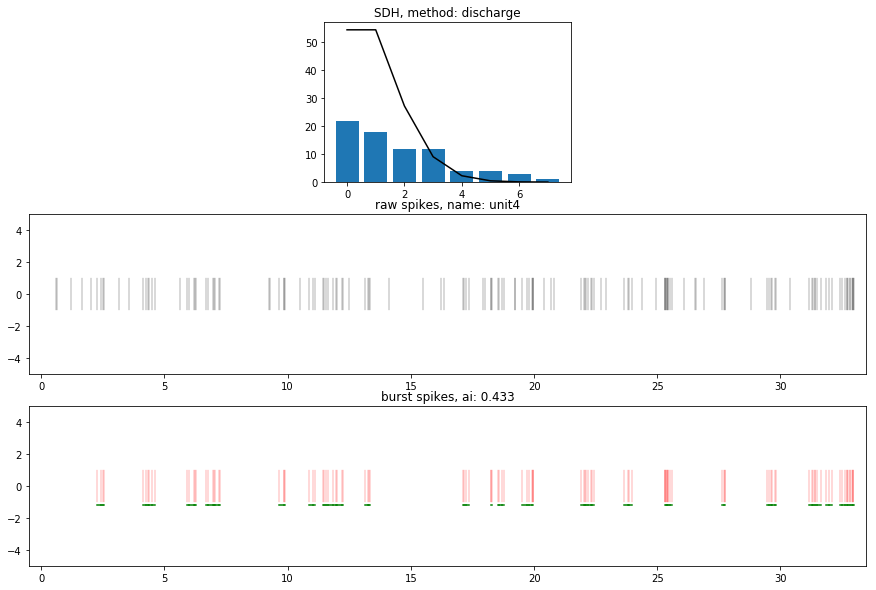

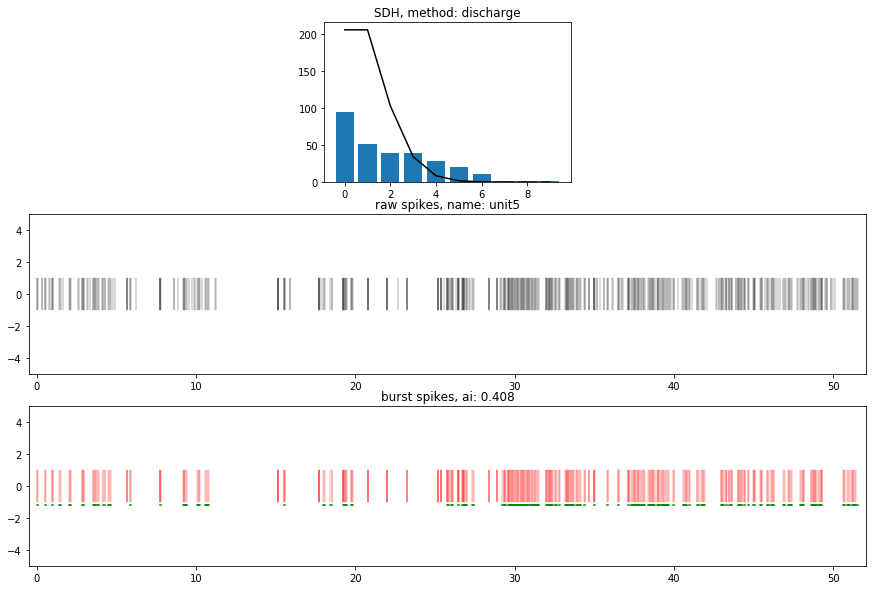

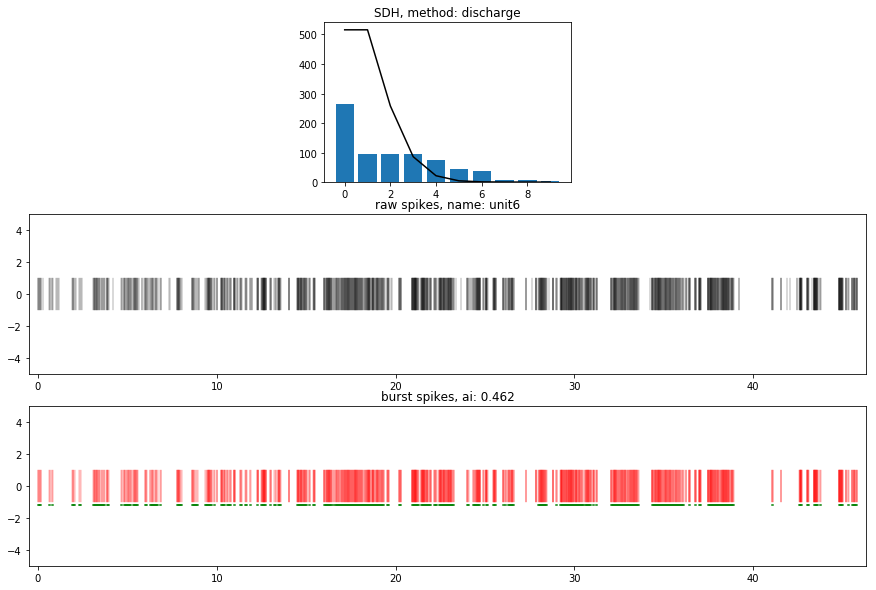

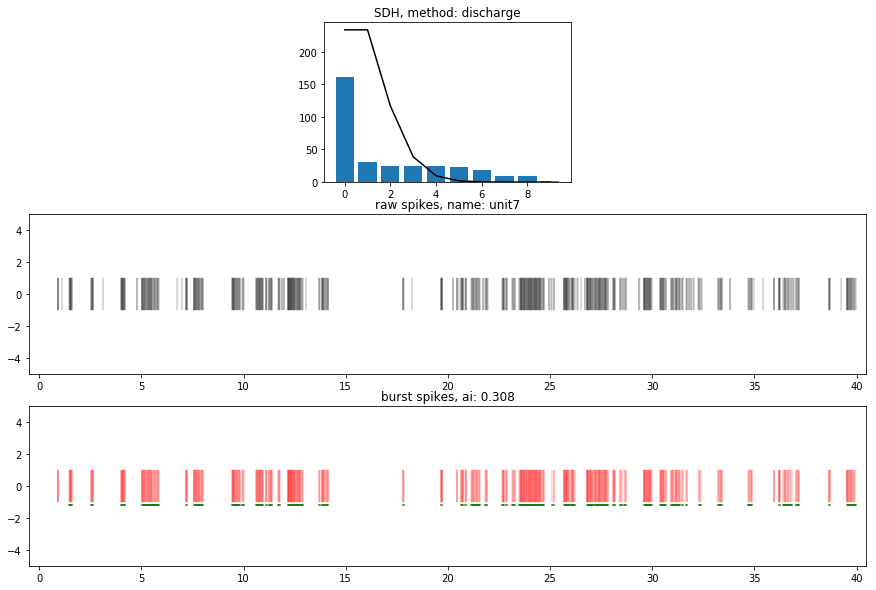

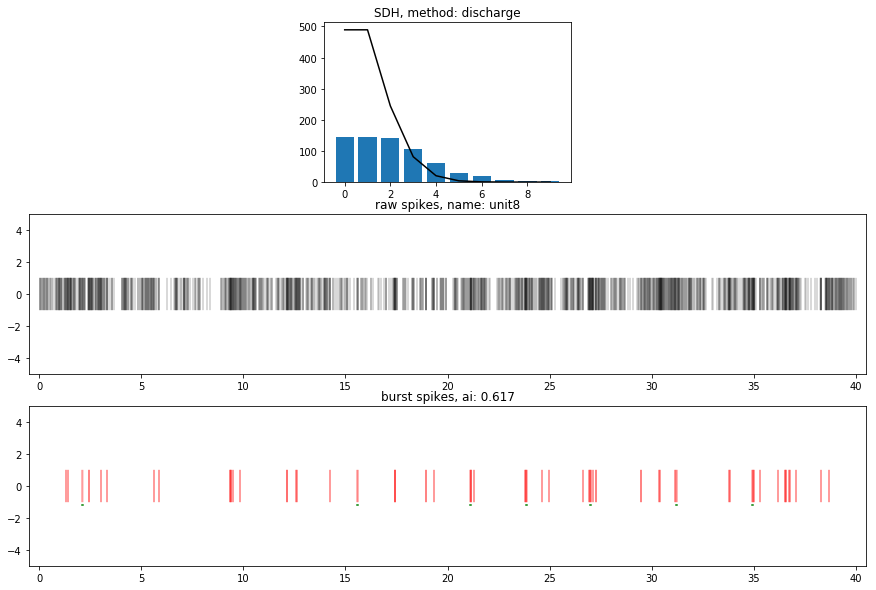

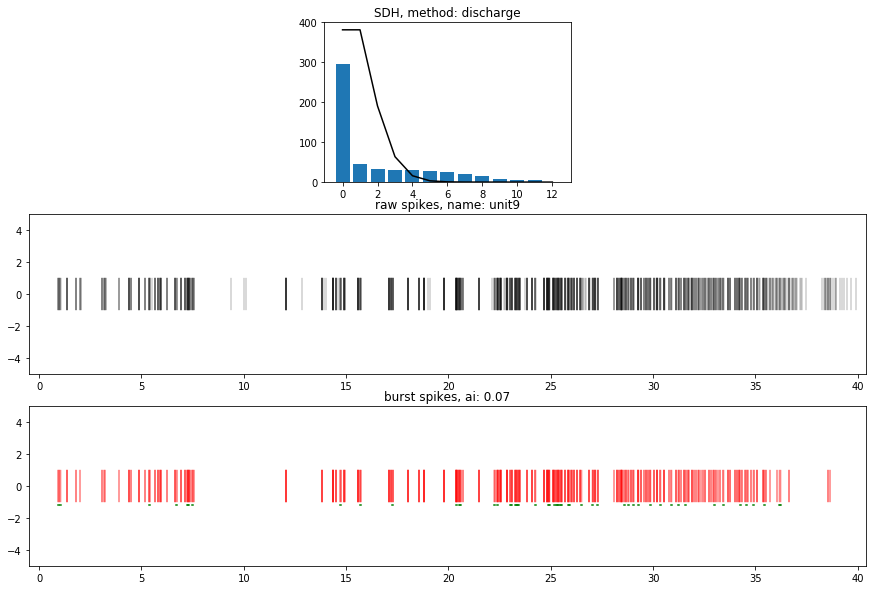

In [36]:
fname = 'pattern_data/All_cells.nex'
r = neo.io.NeuroExplorerIO(fname)

for idxst, (name, spikes) in enumerate(events_iterator(r)):
    if len(spikes) < 50:
        continue
        
    burst_isi, burst_spikes = detect_plot(name, spikes, 'discharge')
    
    plt.savefig('images/{}_{}_double.png'.format(os.path.split(fname)[~0], name))

t: 0.191
isi_t: 0.048
t: 0.33
isi_t: 0.11
t: 0.183
isi_t: 0.023
t: 0.166
isi_t: 0.055
t: 0.091
isi_t: 0.046
t: 0.05
isi_t: 0.025
t: 0.027
isi_t: 0.027
t: 0.341
isi_t: 0.085
t: 0.057
t: 0.321
isi_t: 0.08
t: 0.145
isi_t: 0.048
t: 0.211
isi_t: 0.106
t: 0.329
isi_t: 0.082
t: 0.128
isi_t: 0.128
t: 0.111
isi_t: 0.055
t: 0.096
isi_t: 0.016
t: 0.247
isi_t: 0.062
t: 0.291
isi_t: 0.058
t: 0.238
isi_t: 0.119
t: 0.087
isi_t: 0.044
t: 0.205
isi_t: 0.102


C:\Users\vladka\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


t: 0.042
isi_t: 0.042
t: 0.134
isi_t: 0.067


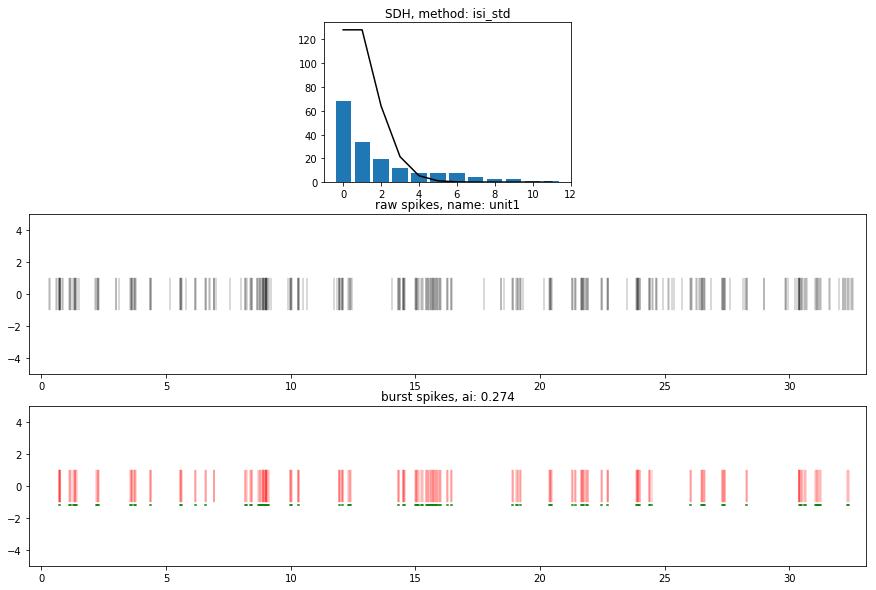

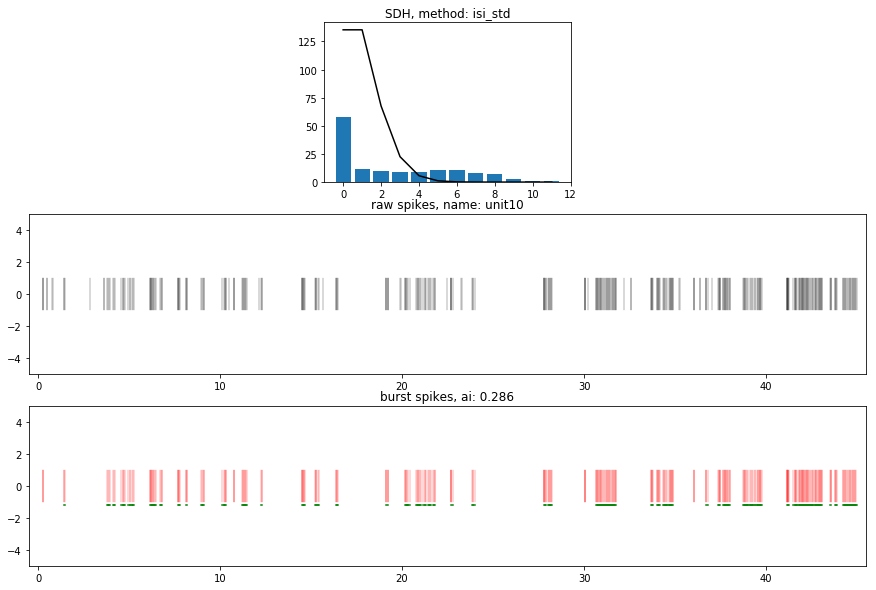

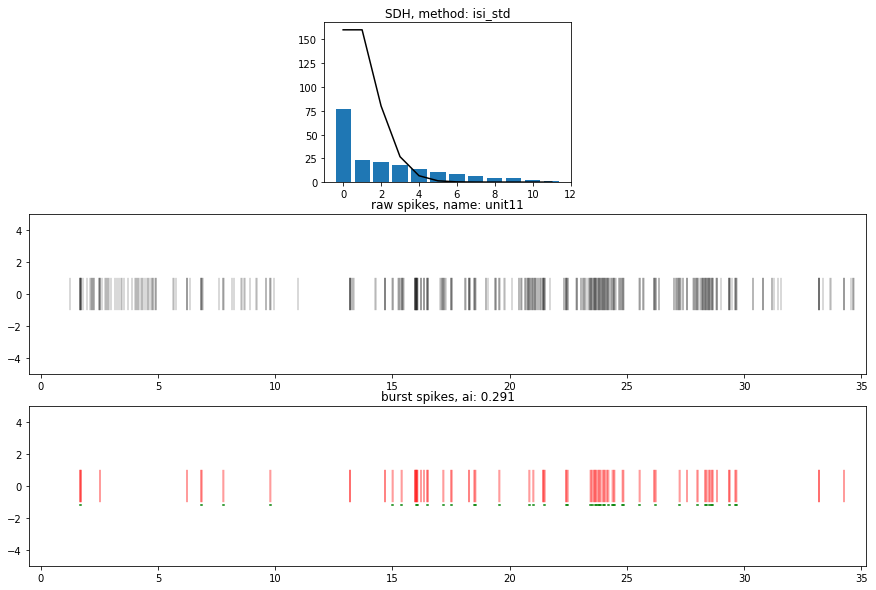

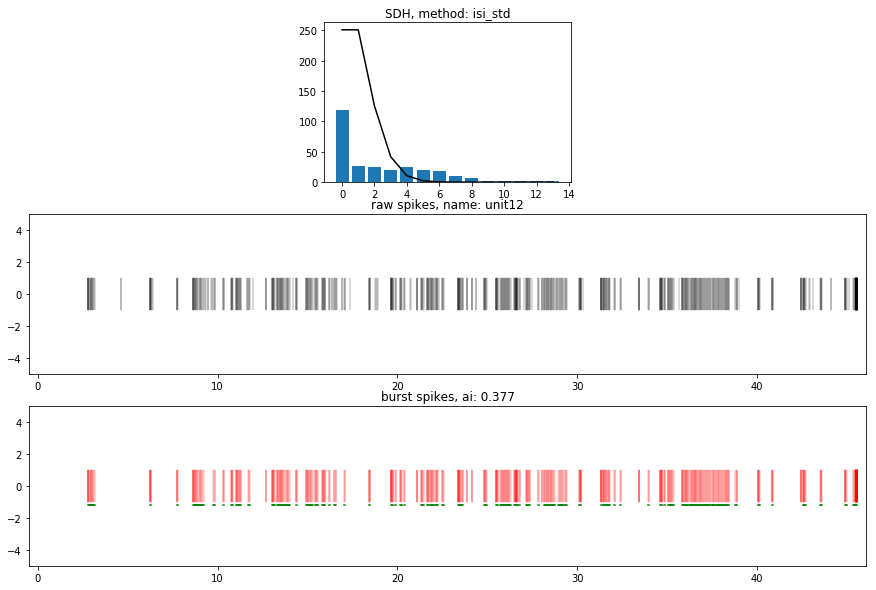

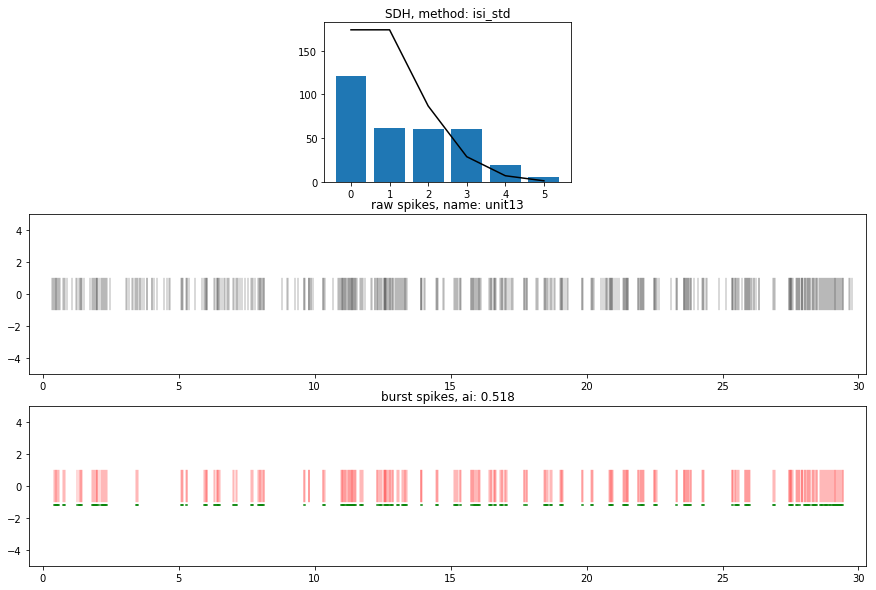

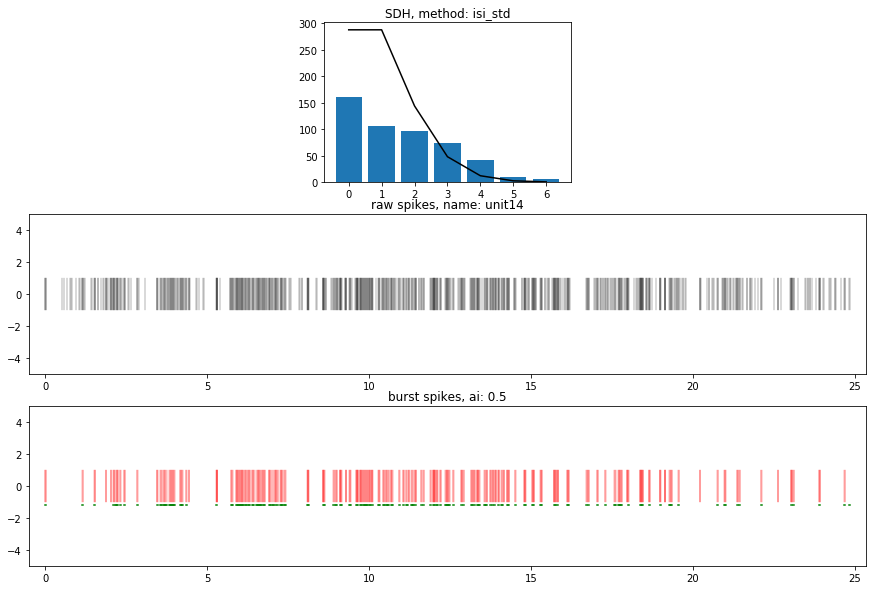

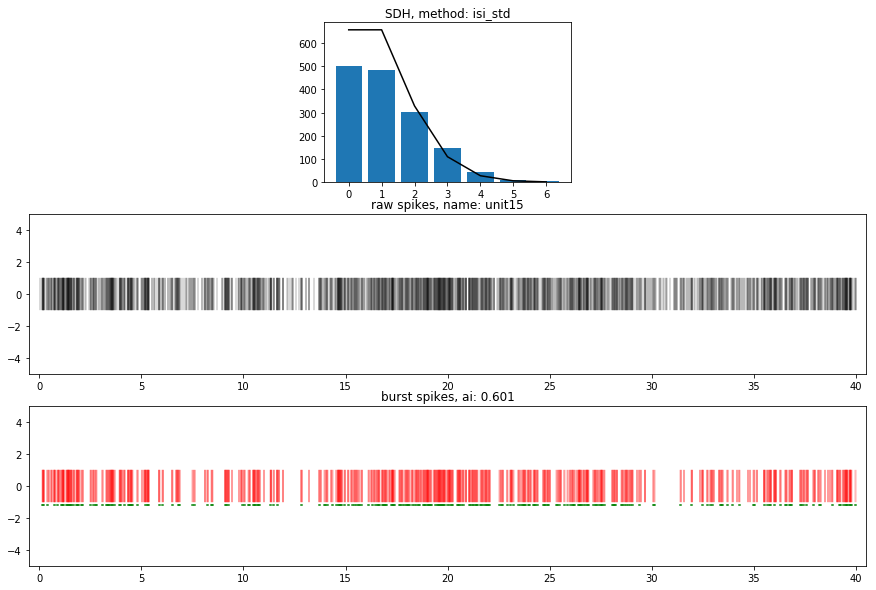

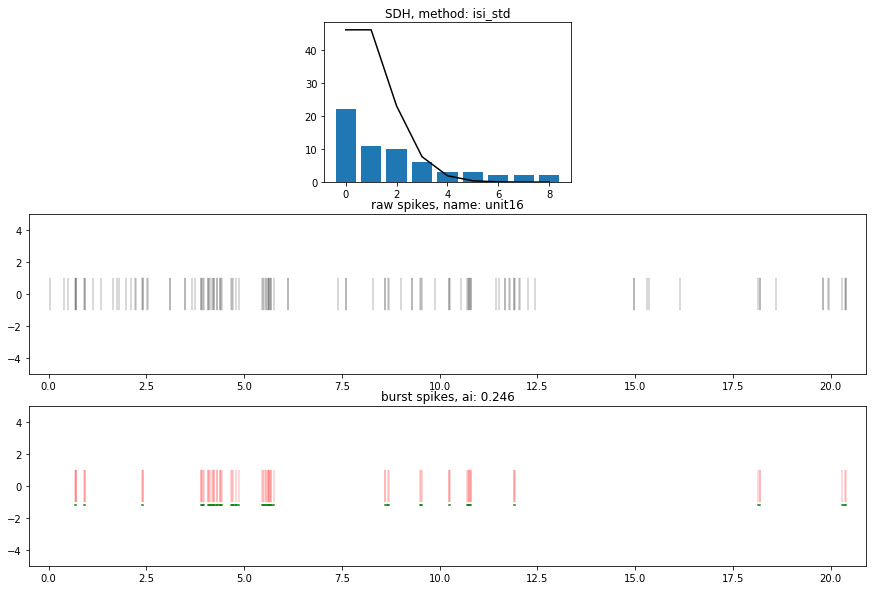

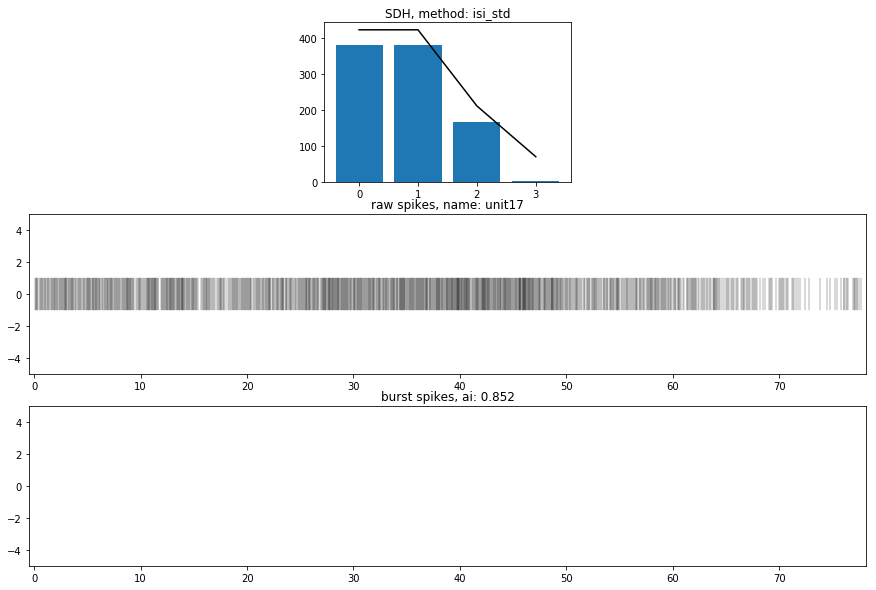

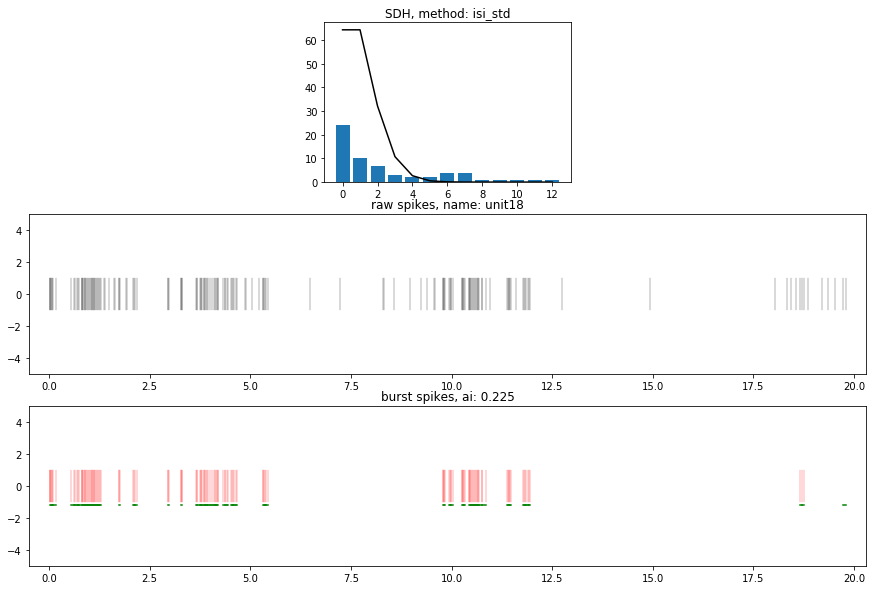

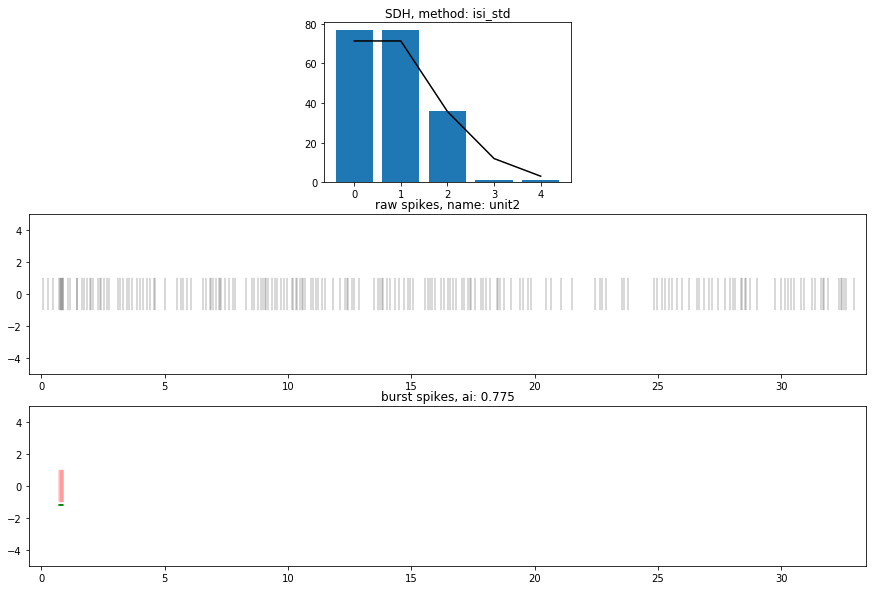

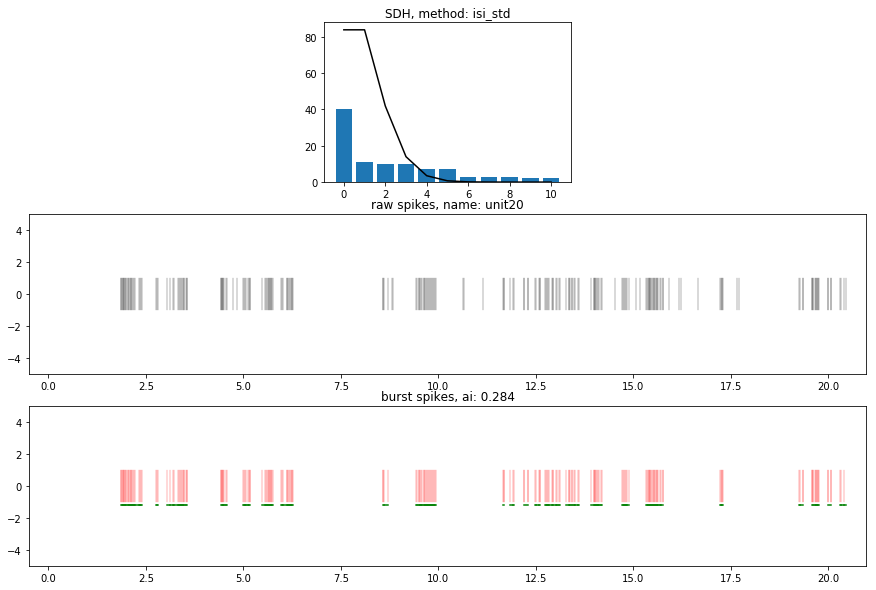

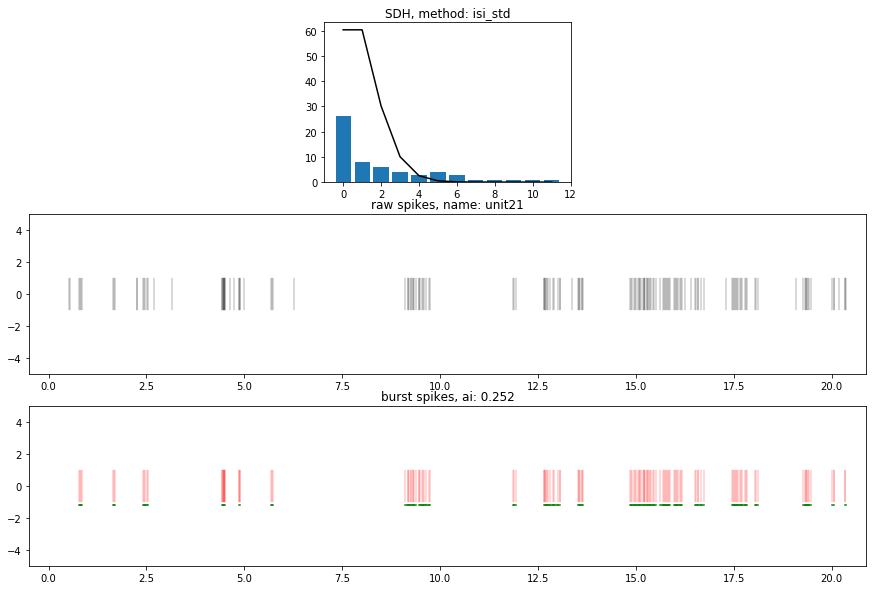

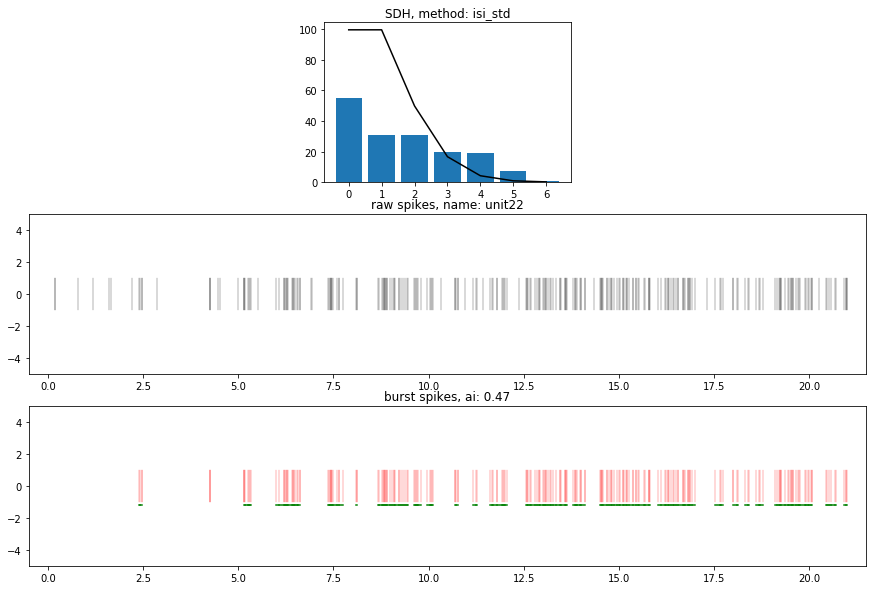

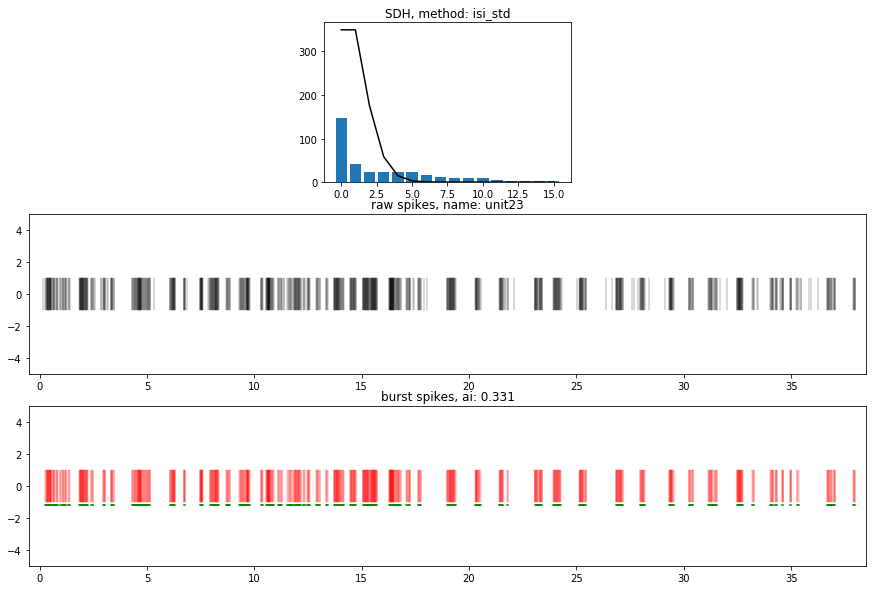

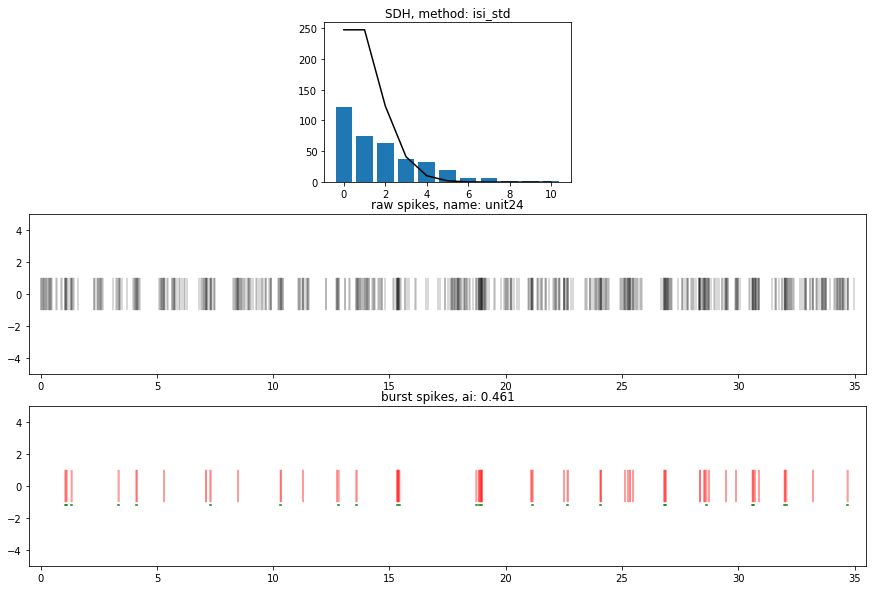

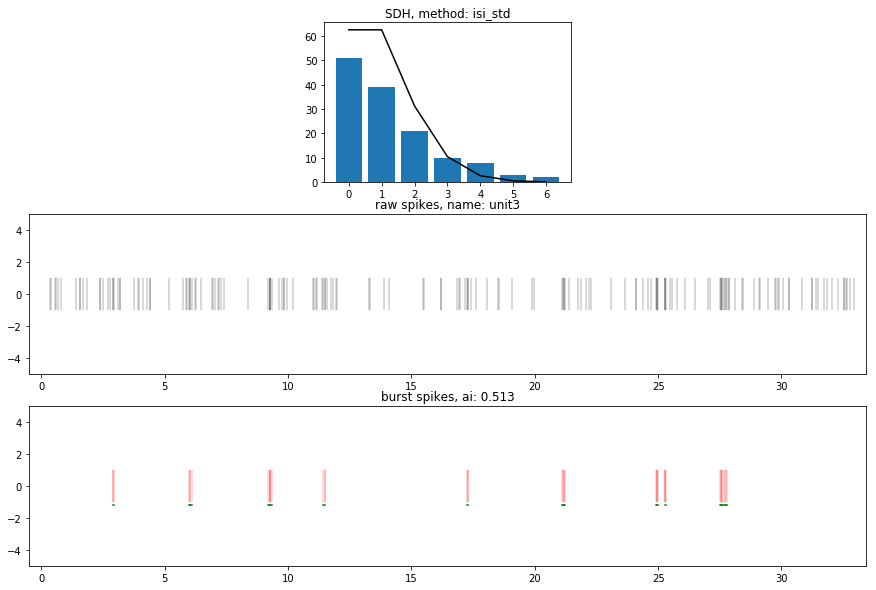

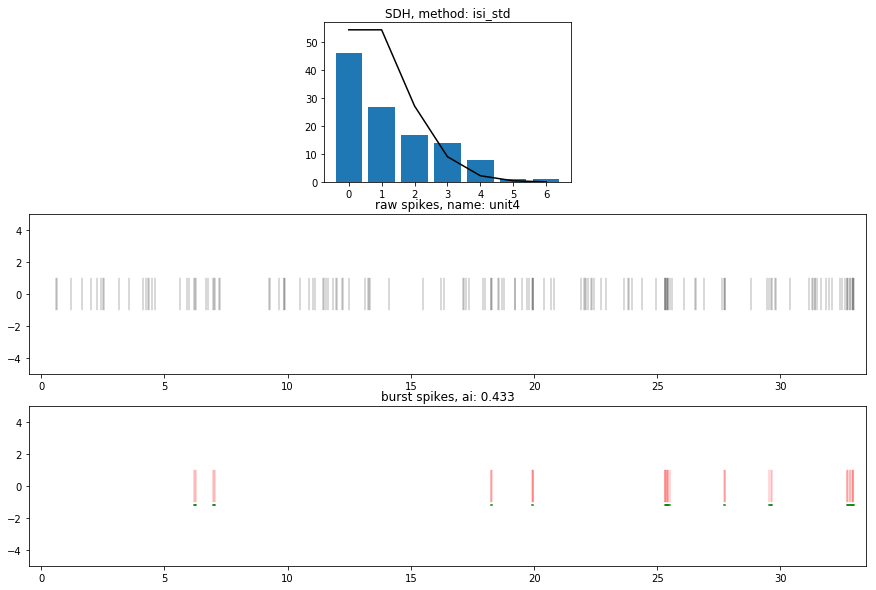

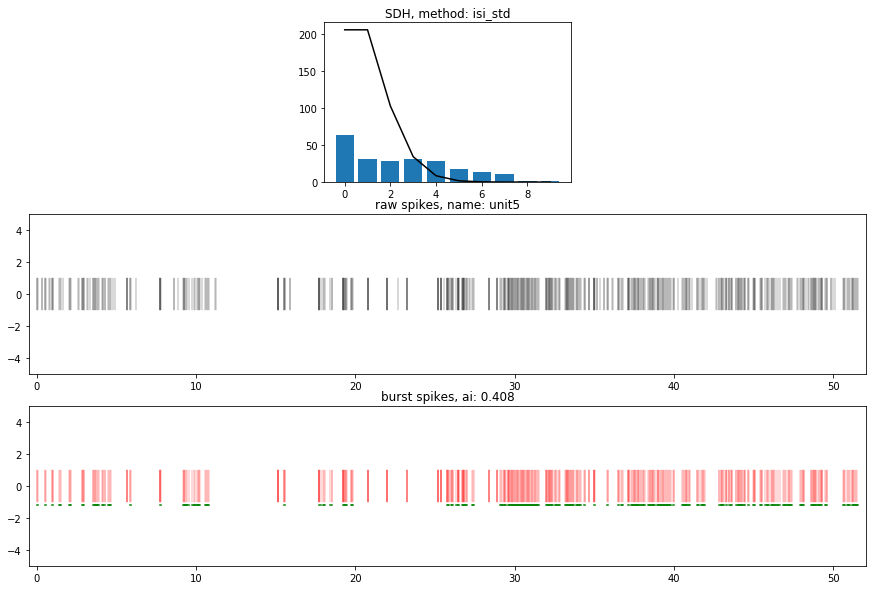

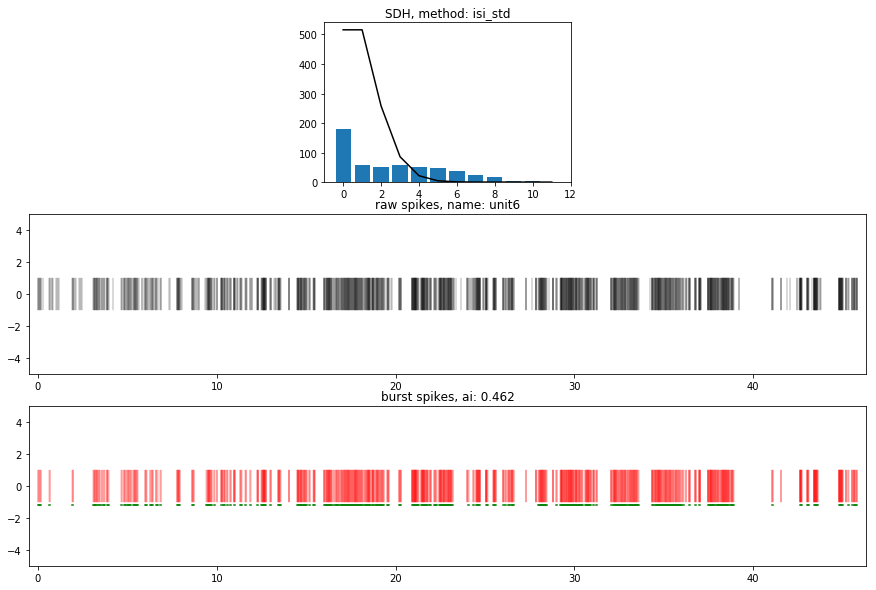

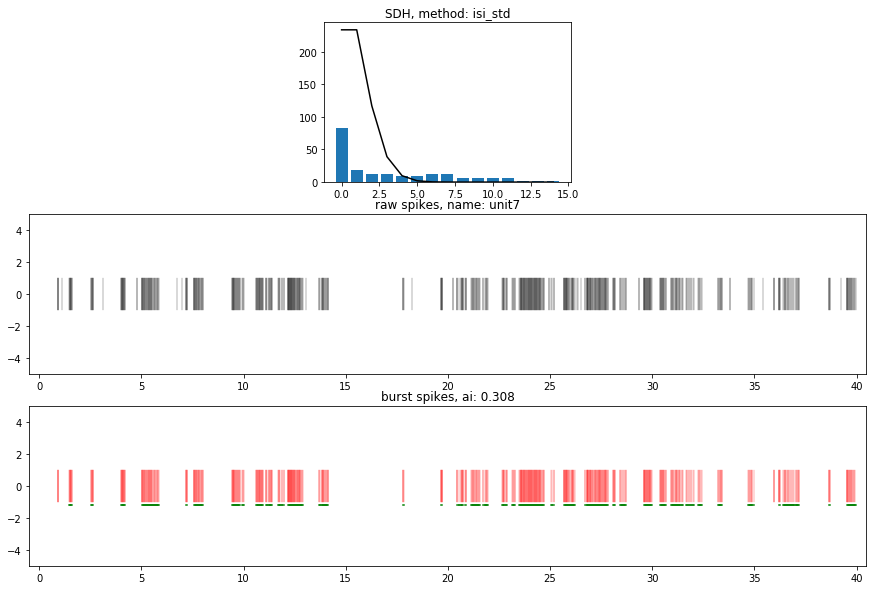

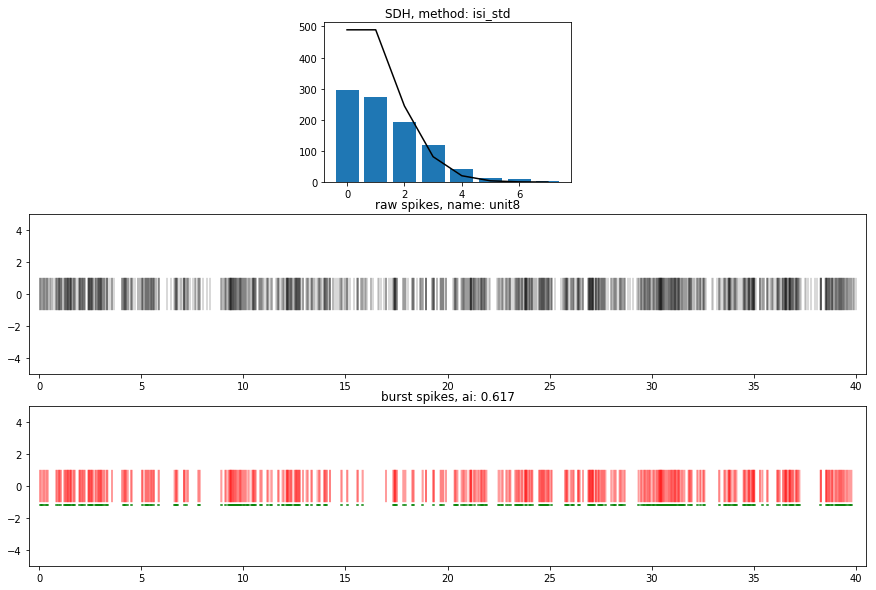

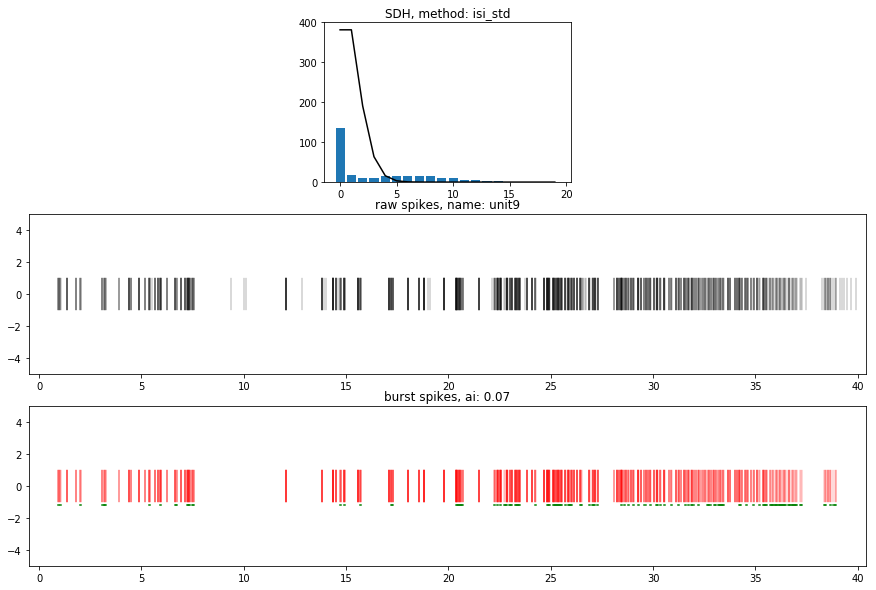

In [37]:
fname = 'pattern_data/All_cells.nex'
r = neo.io.NeuroExplorerIO(fname)

for idxst, (name, spikes) in enumerate(events_iterator(r)):
    if len(spikes) < 50:
        continue
        
    burst_isi, burst_spikes = detect_plot(name, spikes, 'isi_std')
    
    plt.savefig('images/{}_{}_std.png'.format(os.path.split(fname)[~0], name))

In [171]:
# fname = 'pattern_data\\LT2D-0.225t.nex'
# r = neo.io.NeuroExplorerIO(fname)

# for st in spiketrains_iterator(r):
#     nm = st.name
#     if len(st) < 50:
#         continue
        
#     st = np.array(st)
#     spikes_r = ro.FloatVector(st)

#     for mname, mfunc in methods:
#         print(mname)

#         ro.r.assign('spikes', spikes_r)
#         res = pd.DataFrame(ro.r(mfunc))

#         burst_spikes = np.zeros(len(st))
        
#         if 'end' not in res:
#             res['end'] = res['beg'] + res['len'] - 1
            
#         try:
#             idx = zip(map(int, res['beg']), map(int, res['end']))

#             for s, e in idx:
#                 s -= 1
#                 e -= 1
                
#                 burst_spikes[s:e] = True
#         except:
#             pass
        
#         plot_spikes(st, burst_spikes, mname, res, dname=nm)